In [33]:
import requests
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

API_KEY = os.getenv("OPENAQ_API_KEY")
if not API_KEY:
    raise ValueError("Environment variable 'OPENAQ_API_KEY' not found.")

HEADERS = {
    "X-API-Key": API_KEY
}

URL = "https://api.openaq.org/v3/locations"

params = {
    "coordinates": "52.52,13.405",  # Berlin
    "radius": 25000,                # 25 km
    "country": "DE",
    "limit": 100,
    "sort": "asc"
}

response = requests.get(URL, headers=HEADERS, params=params)

if response.status_code == 200:
    results = response.json().get("results", [])
    print(f"Found {len(results)} monitoring stations within 25 km of Berlin:")
    for loc in results:
        print(f"{loc['id']}: {loc['name']}")
else:
    print(f"Request failed with status code {response.status_code}: {response.text}")



Found 27 monitoring stations within 25 km of Berlin:
2993: Berlin Neukölln
3017: Berlin Karlshorst
3019: Berlin Mitte
3021: DEBE064
3025: DEBE063
3026: Berlin Schöneberg
3070: Bernau, Lohmühlenstr.
3096: Potsdam, Groß Glienicke
4582: Berlin Grunewald (3.5 m)
4724: Blankenfelde-Mahlow
4761: Berlin Wedding
4762: Berlin Schildhornstraße
4763: Berlin Marienfelde
4764: Berlin Mariendorfer Damm
4765: Berlin Hardenbergplatz
4766: Berlin Frohnau (3.5 m)
4767: Berlin Frankfurter Allee
4768: Berlin Friedrichshagen
4769: DEBE051
2162174: Dallgow-Döberitz
2162178: Berlin Leipziger Straße (MC)
2162179: Berlin Buch
2162180: Berlin Karl-Marx-Straße II
2162181: Berlin Silbersteinstraße 5
2977853: Berlin-Neukoelln Donaustr.
3349325: Berlin-Neukoelln Donaustrasse North
3527233: Havelstr. Birkenwerder 


In [34]:
import requests
import time
import os
from dotenv import load_dotenv

# Load API key from .env file
load_dotenv()
API_KEY = os.getenv("OPENAQ_API_KEY")
if not API_KEY:
    raise ValueError("Environment variable 'OPENAQ_API_KEY' not found.")

BASE_URL = "https://api.openaq.org/v3"
bbox = "1.45,48.0,3.6,49.2"  # Île-de-France bounding box
parameters = [1, 2, 7, 8, 9, 10]  # PM10, PM2.5, NO2, CO, SO2, O3
REQUEST_DELAY = 1.1  # seconds

def safe_request(url, params=None):
    while True:
        try:
            response = requests.get(url, headers={"X-API-Key": API_KEY}, params=params)
            if response.status_code == 429:
                print("429 Too Many Requests — waiting 10 seconds...")
                time.sleep(10)
                continue
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            time.sleep(5)

def get_locations():
    data = safe_request(f"{BASE_URL}/locations", {"bbox": bbox, "limit": 1000})
    return [loc["id"] for loc in data["results"]]

def get_sensor_ids(location_id):
    data = safe_request(f"{BASE_URL}/locations/{location_id}")
    sensors = data["results"][0].get("sensors", [])
    return [s["id"] for s in sensors if s["parameter"]["id"] in parameters]

def get_yearly_averages(sensor_id):
    params = {
        "date_from": "2019-01-01T00:00:00Z",
        "date_to": "2022-12-31T23:59:59Z",
        "limit": 1000
    }
    return safe_request(f"{BASE_URL}/sensors/{sensor_id}/years", params).get("results", [])

def main():
    all_results = []
    locations = get_locations()[:20]
    print(f"Processing {len(locations)} monitoring stations in Île-de-France...")

    for i, loc_id in enumerate(locations, 1):
        print(f"\nStation {i}/{len(locations)}: ID={loc_id}")
        time.sleep(REQUEST_DELAY)
        sensor_ids = get_sensor_ids(loc_id)
        for sensor_id in sensor_ids:
            time.sleep(REQUEST_DELAY)
            yearly_data = get_yearly_averages(sensor_id)
            for entry in yearly_data:
                result = {
                    "sensor_id": sensor_id,
                    "parameter": entry["parameter"]["name"],
                    "year": entry["period"]["datetimeFrom"]["utc"][:4],
                    "avg": entry["value"]
                }
                all_results.append(result)

    print("\nFinal results:")
    for r in all_results:
        print(r)

if __name__ == "__main__":
    main()



Processing 20 monitoring stations in Île-de-France...

Station 1/20: ID=2674

Station 2/20: ID=2675

Station 3/20: ID=2681

Station 4/20: ID=3699

Station 5/20: ID=3916

Station 6/20: ID=4007

Station 7/20: ID=4011

Station 8/20: ID=4015

Station 9/20: ID=4039

Station 10/20: ID=4041

Station 11/20: ID=4043

Station 12/20: ID=4053

Station 13/20: ID=4058

Station 14/20: ID=4060

Station 15/20: ID=4063

Station 16/20: ID=4066

Station 17/20: ID=4067

Station 18/20: ID=4068

Station 19/20: ID=4069

Station 20/20: ID=4070

Final results:
{'sensor_id': 5588, 'parameter': 'pm10', 'year': '2018', 'avg': 26.4}
{'sensor_id': 5588, 'parameter': 'pm10', 'year': '2019', 'avg': 23.3}
{'sensor_id': 5588, 'parameter': 'pm10', 'year': '2020', 'avg': 24.7}
{'sensor_id': 5588, 'parameter': 'pm10', 'year': '2021', 'avg': 23.6}
{'sensor_id': 8221, 'parameter': 'pm10', 'year': '2018', 'avg': 14.6}
{'sensor_id': 8221, 'parameter': 'pm10', 'year': '2019', 'avg': 12.8}
{'sensor_id': 8221, 'parameter': 'pm10'

In [35]:
import requests
import time
import pandas as pd
import os
from dotenv import load_dotenv

# Load API key from .env file
load_dotenv()
API_KEY = os.getenv("OPENAQ_API_KEY")
if not API_KEY:
    raise ValueError("Environment variable 'OPENAQ_API_KEY' not found.")

BASE_URL = "https://api.openaq.org/v3"
bbox = "1.45,48.0,3.6,49.2"  # Île-de-France bounding box
parameters = [1, 2, 7, 8, 9, 10]  # PM10, PM2.5, NO2, CO, SO2, O3
REQUEST_DELAY = 1.1  # seconds between requests

def safe_request(url, params=None):
    while True:
        try:
            r = requests.get(url, headers={"X-API-Key": API_KEY}, params=params)
            if r.status_code == 429:
                print("429 Too Many Requests — waiting 10 seconds...")
                time.sleep(10)
                continue
            r.raise_for_status()
            return r.json()
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            time.sleep(5)

def get_locations():
    data = safe_request(f"{BASE_URL}/locations", {"bbox": bbox, "limit": 1000})
    return [loc["id"] for loc in data["results"]]

def get_sensor_ids(location_id):
    data = safe_request(f"{BASE_URL}/locations/{location_id}")
    sensors = data["results"][0].get("sensors", [])
    return [s["id"] for s in sensors if s["parameter"]["id"] in parameters]

def get_yearly_averages(sensor_id):
    params = {
        "date_from": "2019-01-01T00:00:00Z",
        "date_to": "2022-12-31T23:59:59Z",
        "limit": 1000
    }
    return safe_request(f"{BASE_URL}/sensors/{sensor_id}/years", params).get("results", [])

def main():
    all_data = []
    locations = get_locations()[:20]
    print(f"Processing {len(locations)} monitoring stations in Île-de-France...\n")

    for i, loc_id in enumerate(locations, 1):
        print(f"Station {i}/{len(locations)}: ID={loc_id}")
        time.sleep(REQUEST_DELAY)
        sensor_ids = get_sensor_ids(loc_id)
        for sensor_id in sensor_ids:
            time.sleep(REQUEST_DELAY)
            yearly_data = get_yearly_averages(sensor_id)
            for entry in yearly_data:
                all_data.append({
                    "sensor_id": sensor_id,
                    "parameter": entry["parameter"]["name"],
                    "year": entry["period"]["datetimeFrom"]["utc"][:4],
                    "value": entry["value"]
                })

    df = pd.DataFrame(all_data)

    if df.empty:
        print("No data to display.")
        return

    summary = (
        df.groupby(["year", "parameter"])
        .agg(avg_value=("value", "mean"), sensor_count=("value", "count"))
        .reset_index()
        .sort_values(by=["year", "parameter"])
    )

    print("\nAnnual average values for Île-de-France (2019–2022):\n")
    print(summary)

    summary.to_csv("idf_air_quality_2019_2022.csv", index=False)
    print("\nData saved to file: idf_air_quality_2019_2022.csv")

if __name__ == "__main__":
    main()



Processing 20 monitoring stations in Île-de-France...

Station 1/20: ID=2674
Station 2/20: ID=2675
Station 3/20: ID=2681
Station 4/20: ID=3699
Station 5/20: ID=3916
Station 6/20: ID=4007
Station 7/20: ID=4011
Station 8/20: ID=4015
Station 9/20: ID=4039
Station 10/20: ID=4041
Station 11/20: ID=4043
Station 12/20: ID=4053
Station 13/20: ID=4058
Station 14/20: ID=4060
Station 15/20: ID=4063
Station 16/20: ID=4066
Station 17/20: ID=4067
Station 18/20: ID=4068
Station 19/20: ID=4069
Station 20/20: ID=4070

Annual average values for Île-de-France (2019–2022):

   year parameter  avg_value  sensor_count
0  2018      pm10  23.350000            12
1  2018      pm25  13.670000             4
2  2019      pm10  21.607692            13
3  2019      pm25  12.875000             4
4  2020      pm10  23.576923            13
5  2020      pm25  13.410000             5
6  2021      pm10  22.507692            13
7  2021      pm25  11.734286             7

Data saved to file: idf_air_quality_2019_2022.csv


In [36]:
import requests
import time
import pandas as pd
from datetime import datetime
import os
from dotenv import load_dotenv

# Load API key from .env
load_dotenv()
API_KEY = os.getenv("OPENAQ_API_KEY")
if not API_KEY:
    raise ValueError("Environment variable 'OPENAQ_API_KEY' is missing.")

BASE_URL = "https://api.openaq.org/v3"
bbox = "1.45,48.0,3.6,49.2"  # Île-de-France bounding box
REQUEST_DELAY = 1.1  # seconds

def safe_request(url, params=None):
    while True:
        try:
            r = requests.get(url, headers={"X-API-Key": API_KEY}, params=params)
            if r.status_code == 429:
                print("429 Too Many Requests — waiting 10 seconds...")
                time.sleep(10)
                continue
            r.raise_for_status()
            return r.json()
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            time.sleep(5)

def get_all_locations():
    url = f"{BASE_URL}/locations"
    params = {
        "bbox": bbox,
        "limit": 1000
    }
    headers = {"X-API-Key": API_KEY}
    r = requests.get(url, headers=headers, params=params)
    r.raise_for_status()
    return r.json()["results"]

def get_pm25_sensor_ids(locations):
    sensor_ids = []
    for loc in locations:
        for sensor in loc.get("sensors", []):
            if sensor["parameter"]["name"] == "pm25":
                sensor_ids.append(sensor["id"])
    return sensor_ids

def get_monthly_pm25(sensor_id):
    url = f"{BASE_URL}/sensors/{sensor_id}/days/monthly"
    params = {
        "date_from": "2018-01-01T00:00:00Z",
        "date_to": "2023-12-31T23:59:59Z",
        "limit": 1000
    }
    results = safe_request(url, params).get("results", [])
    data = []
    for item in results:
        period = item["period"]["datetimeFrom"]["utc"]
        dt = datetime.fromisoformat(period.replace("Z", "+00:00"))
        data.append({
            "sensor_id": sensor_id,
            "year": dt.year,
            "month": dt.month,
            "value": item["value"]
        })
    return data

def main():
    all_data = []
    print("Loading monitoring stations in Île-de-France...")
    locations = get_all_locations()
    print(f"Found {len(locations)} stations.")

    sensor_ids = get_pm25_sensor_ids(locations)
    print(f"Found {len(sensor_ids)} sensors measuring PM2.5.")

    for i, sensor_id in enumerate(sensor_ids, 1):
        print(f"Fetching data from sensor {i}/{len(sensor_ids)} (ID={sensor_id})")
        time.sleep(REQUEST_DELAY)
        monthly_data = get_monthly_pm25(sensor_id)
        all_data.extend(monthly_data)

    df = pd.DataFrame(all_data)
    if df.empty:
        print("No PM2.5 data available.")
        return

    summary = (
        df.groupby(["year", "month"])
        .agg(avg_value=("value", "mean"), sensor_count=("value", "count"))
        .reset_index()
        .sort_values(by=["year", "month"])
    )

    print("\nMonthly average PM2.5 values for Île-de-France (2018–2023):")
    print(summary)

    summary.to_csv("idf_pm25_monthly_2018_2023.csv", index=False)
    print("\nData saved to file: idf_pm25_monthly_2018_2023.csv")

if __name__ == "__main__":
    main()



Loading monitoring stations in Île-de-France...
Found 79 stations.
Found 41 sensors measuring PM2.5.
Fetching data from sensor 1/41 (ID=1298714)
Fetching data from sensor 2/41 (ID=9482)
Fetching data from sensor 3/41 (ID=1582598)
Fetching data from sensor 4/41 (ID=9548)
Fetching data from sensor 5/41 (ID=9596)
Fetching data from sensor 6/41 (ID=5078993)
Fetching data from sensor 7/41 (ID=9588)
Fetching data from sensor 8/41 (ID=9589)
Fetching data from sensor 9/41 (ID=4442231)
Fetching data from sensor 10/41 (ID=5078801)
Fetching data from sensor 11/41 (ID=1562368)
Fetching data from sensor 12/41 (ID=4661655)
Fetching data from sensor 13/41 (ID=9646)
Fetching data from sensor 14/41 (ID=9663)
Fetching data from sensor 15/41 (ID=9681)
Fetching data from sensor 16/41 (ID=9702)
Fetching data from sensor 17/41 (ID=5078428)
Fetching data from sensor 18/41 (ID=9733)
Fetching data from sensor 19/41 (ID=1562192)
Fetching data from sensor 20/41 (ID=9865)
Fetching data from sensor 21/41 (ID=15303

In [37]:
import requests
import time
import pandas as pd
from datetime import datetime
import os
from dotenv import load_dotenv

# Load API key from .env
load_dotenv()
API_KEY = os.getenv("OPENAQ_API_KEY")
if not API_KEY:
    raise ValueError("Environment variable 'OPENAQ_API_KEY' is missing.")

BASE_URL = "https://api.openaq.org/v3"
REQUEST_DELAY = 1.1  # seconds

def safe_request(url, params=None):
    while True:
        try:
            r = requests.get(url, headers={"X-API-Key": API_KEY}, params=params)
            if r.status_code == 429:
                print("429 Too Many Requests — waiting 10 seconds...")
                time.sleep(10)
                continue
            r.raise_for_status()
            return r.json()
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            time.sleep(5)

def get_all_locations(bbox):
    url = f"{BASE_URL}/locations"
    params = {"bbox": bbox, "limit": 1000}
    return safe_request(url, params)["results"]

def get_pm25_sensor_ids(locations):
    sensor_ids = []
    for loc in locations:
        for sensor in loc.get("sensors", []):
            if sensor["parameter"]["name"] == "pm25":
                sensor_ids.append(sensor["id"])
    return sensor_ids

def get_monthly_pm25(sensor_id):
    url = f"{BASE_URL}/sensors/{sensor_id}/days/monthly"
    params = {
        "date_from": "2018-01-01T00:00:00Z",
        "date_to": "2023-12-31T23:59:59Z",
        "limit": 1000
    }
    results = safe_request(url, params).get("results", [])
    data = []
    for item in results:
        period = item["period"]["datetimeFrom"]["utc"]
        dt = datetime.fromisoformat(period.replace("Z", "+00:00"))
        data.append({
            "sensor_id": sensor_id,
            "year": dt.year,
            "month": dt.month,
            "value": item["value"]
        })
    return data

def process_region(region_name, bbox):
    print(f"\nProcessing region: {region_name}")
    locations = get_all_locations(bbox)
    print(f"Found {len(locations)} stations")

    sensor_ids = get_pm25_sensor_ids(locations)
    print(f"Found {len(sensor_ids)} PM2.5 sensors")

    all_data = []
    for i, sensor_id in enumerate(sensor_ids, 1):
        print(f"Processing sensor {i}/{len(sensor_ids)}: ID={sensor_id}")
        time.sleep(REQUEST_DELAY)
        all_data.extend(get_monthly_pm25(sensor_id))

    df = pd.DataFrame(all_data)
    if df.empty:
        print("No PM2.5 data available for this region.")
        return

    summary = (
        df.groupby(["year", "month"])
        .agg(avg_value=("value", "mean"), sensor_count=("value", "count"))
        .reset_index()
        .sort_values(by=["year", "month"])
    )

    filename = f"{region_name.lower().replace(' ', '_')}_pm25_monthly_2018_2023.csv"
    summary.to_csv(filename, index=False)
    print(f"Data saved to file: {filename}")
    print(summary.head())

if __name__ == "__main__":
    process_region("Occitanie", "-0.1,42.3,4.9,45.2")
    process_region("Auvergne-Rhône-Alpes", "3.0,44.0,7.4,46.4")




Processing region: Occitanie
Found 111 stations
Found 52 PM2.5 sensors
Processing sensor 1/52: ID=5672
Processing sensor 2/52: ID=7120203
Processing sensor 3/52: ID=7923
Processing sensor 4/52: ID=15374
Processing sensor 5/52: ID=7703
Processing sensor 6/52: ID=7704
Processing sensor 7/52: ID=7852
Processing sensor 8/52: ID=7854
Processing sensor 9/52: ID=7879
Processing sensor 10/52: ID=7884
Processing sensor 11/52: ID=7889
Processing sensor 12/52: ID=12951387
Processing sensor 13/52: ID=7480206
Processing sensor 14/52: ID=24874
Processing sensor 15/52: ID=2021048
Processing sensor 16/52: ID=5078877
Processing sensor 17/52: ID=8051
Processing sensor 18/52: ID=8107
Processing sensor 19/52: ID=1314203
Processing sensor 20/52: ID=7480204
Processing sensor 21/52: ID=5079023
Processing sensor 22/52: ID=24881
Processing sensor 23/52: ID=5078419
Processing sensor 24/52: ID=5078515
Processing sensor 25/52: ID=2020965
Processing sensor 26/52: ID=13917
Processing sensor 27/52: ID=15376
Process

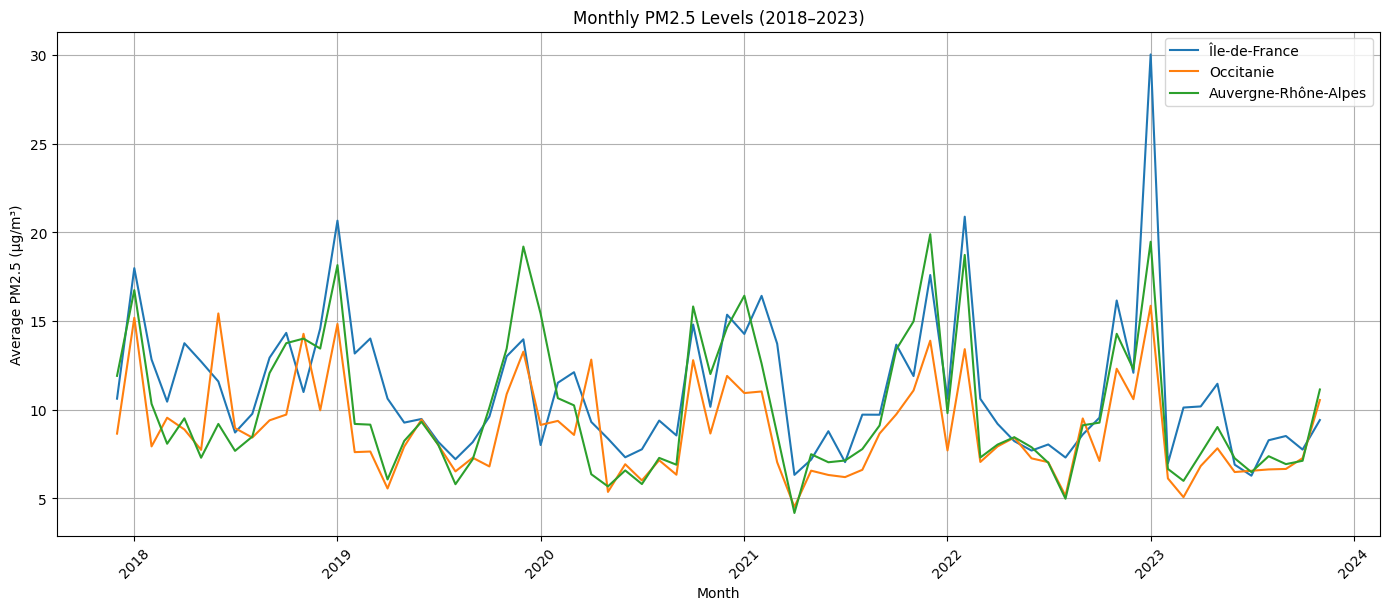

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Define CSV file names and corresponding region labels
files = {
    "idf_pm25_monthly_2018_2023.csv": "Île-de-France",
    "occitanie_pm25_monthly_2018_2023.csv": "Occitanie",
    "auvergne-rhône-alpes_pm25_monthly_2018_2023.csv": "Auvergne-Rhône-Alpes"
}

# Load and combine data
dfs = []
for file, region in files.items():
    df = pd.read_csv(file)
    df["region"] = region
    dfs.append(df)

data = pd.concat(dfs)

# Create a datetime column for x-axis
data["year_month"] = pd.to_datetime(data["year"].astype(str) + "-" + data["month"].astype(str))

# Plot PM2.5 monthly trends
plt.figure(figsize=(14, 6))

for region in data["region"].unique():
    region_data = data[data["region"] == region]
    plt.plot(region_data["year_month"], region_data["avg_value"], label=region)

plt.title("Monthly PM2.5 Levels (2018–2023)")
plt.xlabel("Month")
plt.ylabel("Average PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()



In [39]:
import requests
import time
import pandas as pd
from datetime import datetime
import os
from dotenv import load_dotenv

# Load API key from .env
load_dotenv()
API_KEY = os.getenv("OPENAQ_API_KEY")
if not API_KEY:
    raise ValueError("Environment variable 'OPENAQ_API_KEY' is missing.")

BASE_URL = "https://api.openaq.org/v3"
REQUEST_DELAY = 1.1  # seconds between API requests

def safe_request(url, params=None):
    while True:
        try:
            response = requests.get(url, headers={"X-API-Key": API_KEY}, params=params)
            if response.status_code == 429:
                print("429 Too Many Requests — waiting 10 seconds...")
                time.sleep(10)
                continue
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            time.sleep(5)

def get_all_locations(bbox):
    url = f"{BASE_URL}/locations"
    params = {"bbox": bbox, "limit": 1000}
    return safe_request(url, params)["results"]

def get_pm10_sensor_ids(locations):
    sensor_ids = []
    for loc in locations:
        for sensor in loc.get("sensors", []):
            if sensor["parameter"]["name"] == "pm10":
                sensor_ids.append(sensor["id"])
    return sensor_ids

def get_monthly_pm10(sensor_id):
    url = f"{BASE_URL}/sensors/{sensor_id}/days/monthly"
    params = {
        "date_from": "2018-01-01T00:00:00Z",
        "date_to": "2023-12-31T23:59:59Z",
        "limit": 1000
    }
    results = safe_request(url, params).get("results", [])
    data = []
    for item in results:
        period = item["period"]["datetimeFrom"]["utc"]
        dt = datetime.fromisoformat(period.replace("Z", "+00:00"))
        data.append({
            "sensor_id": sensor_id,
            "year": dt.year,
            "month": dt.month,
            "value": item["value"]
        })
    return data

def process_region(region_name, bbox):
    print(f"\nProcessing region: {region_name}")
    locations = get_all_locations(bbox)
    print(f"Found {len(locations)} monitoring stations")

    sensor_ids = get_pm10_sensor_ids(locations)
    print(f"Found {len(sensor_ids)} PM10 sensors")

    all_data = []
    for i, sensor_id in enumerate(sensor_ids, 1):
        print(f"Processing sensor {i}/{len(sensor_ids)}: ID={sensor_id}")
        time.sleep(REQUEST_DELAY)
        all_data.extend(get_monthly_pm10(sensor_id))

    df = pd.DataFrame(all_data)
    if df.empty:
        print("No PM10 data found for this region.")
        return

    summary = (
        df.groupby(["year", "month"])
        .agg(avg_value=("value", "mean"), sensor_count=("value", "count"))
        .reset_index()
        .sort_values(by=["year", "month"])
    )

    filename = f"{region_name.lower().replace(' ', '_')}_pm10_monthly_2018_2023.csv"
    summary.to_csv(filename, index=False)
    print(f"Data saved to file: {filename}")
    print(summary.head())

# Run for selected regions
if __name__ == "__main__":
    process_region("Occitanie", "-0.1,42.3,4.9,45.2")
    process_region("Auvergne-Rhône-Alpes", "3.0,44.0,7.4,46.4")
    process_region("Île-de-France", "1.45,48.0,3.6,49.2")





Processing region: Occitanie
Found 111 monitoring stations
Found 70 PM10 sensors
Processing sensor 1/70: ID=15370
Processing sensor 2/70: ID=5595
Processing sensor 3/70: ID=5671
Processing sensor 4/70: ID=2683691
Processing sensor 5/70: ID=2683693
Processing sensor 6/70: ID=15373
Processing sensor 7/70: ID=7805
Processing sensor 8/70: ID=8607
Processing sensor 9/70: ID=7705
Processing sensor 10/70: ID=7728
Processing sensor 11/70: ID=7964
Processing sensor 12/70: ID=7855
Processing sensor 13/70: ID=7870
Processing sensor 14/70: ID=13944
Processing sensor 15/70: ID=7881
Processing sensor 16/70: ID=15372
Processing sensor 17/70: ID=15377
Processing sensor 18/70: ID=7950
Processing sensor 19/70: ID=8113
Processing sensor 20/70: ID=7953
Processing sensor 21/70: ID=5078888
Processing sensor 22/70: ID=8052
Processing sensor 23/70: ID=8106
Processing sensor 24/70: ID=8141
Processing sensor 25/70: ID=8382
Processing sensor 26/70: ID=8392
Processing sensor 27/70: ID=15408
Processing sensor 28/